In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
def build_model_frame(df):
    """
    Create a leak-free modeling frame for forecasting dwelling_starts per province.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least: 'quarter', 'province',
        'dwelling_starts', 'pop_change_q', 'needed_units_q'

    Returns
    -------
    model_df : pandas.DataFrame
        Long-form table with lag features, ready for modeling.
    """
    # sort to guarantee time order within each province
    df = df.sort_values(["province", "quarter"]).copy()
    df["quarter"] = pd.PeriodIndex(df['quarter'], freq='Q').to_timestamp()

    # target
    df["y"] = df["dwelling_starts"]

    # same-quarter-last-year lag (4 quarters back) for the seasonal baseline model (if i want to forecast same q next year)
    for col in ["dwelling_starts", "pop_change_q", "needed_units_q"]:
        df[f"{col}_lag4"] = df.groupby("province")[col].shift(4)

    '''# same-quarter-last-year lag (4 quarters back) for the seasonal baseline model (if i want to forecast same q next year)
    df["dwelling_starts_lag4"] = df.groupby("province")["dwelling_starts"].shift(4)
    '''
    '''
     # extra seasonal memory (optional, mild improvement)
    df["dwelling_starts_lag8"] = df.groupby("province")["dwelling_starts"].shift(8)

    # quarter dummies (Q2–Q4; Q1 baseline)
    qdum = pd.get_dummies(df["quarter"].dt.quarter, prefix="q")
    df = pd.concat([df, qdum[[c for c in qdum.columns if c != "q_1"]]], axis=1)

    # simple rolling mean at t-4 for smoothing
    df["starts_ma4_lag4"] = (
        df.groupby("province")["dwelling_starts"]
        .transform(lambda x: x.rolling(4).mean().shift(4))  
    ) 
    '''
    
    # drop rows where any lag is missing (first few quarters per province)
    feat_cols = [
    "dwelling_starts_lag4", #"dwelling_starts_lag8",
    "needed_units_q_lag4", "pop_change_q_lag4",
    #"starts_ma4_lag4", "q_2", "q_3", "q_4"
    ]
    model_df = df.dropna(subset=["y"] + feat_cols).reset_index(drop=True)

    return model_df, feat_cols


In [4]:
df = pd.read_csv('data/housing_adequacy_dataset.csv')

model_df, feat_cols = build_model_frame(df)

In [5]:
model_df

,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,y,dwelling_starts_lag4,pop_change_q_lag4,needed_units_q_lag4
0,1991-04-01,ab,2580625.0,12.852333,3.213083,3213.083333,7678.0,3071.2,1.046198,3213.083333,5372.583333,12565.0,5026.0
1,1991-07-01,ab,2592306.0,13.536333,3.384083,3384.083333,11681.0,4672.4,0.724271,3384.083333,3461.750000,15167.0,6066.8
2,1991-10-01,ab,2604031.0,14.018000,3.504500,3504.500000,11725.0,4690.0,0.747228,3504.500000,2930.833333,15354.0,6141.6
3,1992-01-01,ab,2611786.0,16.100333,4.025083,4025.083333,7755.0,3102.0,1.297577,4025.083333,2123.666667,9805.0,3922.0
4,1992-04-01,ab,2620771.0,17.638333,4.409583,4409.583333,8985.0,3594.0,1.226929,4409.583333,3213.083333,7678.0,3071.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,2024-07-01,sk,1247868.0,5.716333,1.429083,1429.083333,9277.0,3710.8,0.385115,1429.083333,1263.000000,8633.0,3453.2
1514,2024-10-01,sk,1256983.0,4.590667,1.147667,1147.666667,9115.0,3646.0,0.314774,1147.666667,1316.833333,11895.0,4758.0
1515,2025-01-01,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,1525.416667,840.583333,8164.0,3265.6
1516,2025-04-01,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,1529.666667,883.333333,8275.0,3310.0


In [6]:
model_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518 entries, 0 to 1517
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   quarter               1518 non-null   datetime64[ns]
 1   province              1518 non-null   object        
 2   population            1518 non-null   float64       
 3   starts_saar           1518 non-null   float64       
 4   starts_saar_q         1518 non-null   float64       
 5   dwelling_starts       1518 non-null   float64       
 6   pop_change_q          1518 non-null   float64       
 7   needed_units_q        1518 non-null   float64       
 8   hai                   1518 non-null   float64       
 9   y                     1518 non-null   float64       
 10  dwelling_starts_lag4  1518 non-null   float64       
 11  pop_change_q_lag4     1518 non-null   float64       
 12  needed_units_q_lag4   1518 non-null   float64       
dtypes: datetime64[ns](

In [7]:
feat_cols

['dwelling_starts_lag4', 'needed_units_q_lag4', 'pop_change_q_lag4']

In [8]:
#checking and converting the quarter to datetime if it was object before
if model_df["quarter"].dtype == "O":
    model_df['quarter'] = pd.PeriodIndex(model_df['quarter'], freq='Q').to_timestamp()

## Data splitting

In [9]:
def chrono_split(df, cutoff="2018-12-31"):
    
    cutoff = pd.Timestamp(cutoff)
    tr = df[df["quarter"] <= cutoff].copy()
    te = df[df["quarter"] >  cutoff].copy()
    return tr, te

"""
    Expanding-window backtest.
      - initial: first train end date (Timestamp or str). If None, uses 60% of timeline.
      - step: how many quarters to advance the train end each fold.
      - fh: forecast horizon in quarters (size of the test slice each fold).
    Yields (train_df, test_df) pairs over the whole *panel* (all provinces).
"""
def rolling_split(df,
                  initial=None,
                  step=1,
                  fh=2):
 
    dates = np.sort(df["quarter"].unique())
    if initial is None:
        initial = dates[int(0.6 * len(dates))]
    else:
        initial = pd.Timestamp(initial)

    # find index of initial in the date array
    # (if not exact, snap to the nearest past available quarter)
    start_idx = np.searchsorted(dates, initial, side="right") - 1
    start_idx = max(start_idx, 0)

    for i in range(start_idx, len(dates) - fh, step):
        train_end = dates[i]
        test_slice = dates[i+1 : i+1+fh]
        tr = df[df["quarter"] <= train_end].copy()
        te = df[df["quarter"].isin(test_slice)].copy()
        if not te.empty:
            yield tr, te

In [10]:
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8 #to avoid a zero denominator
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))
    return {"MAE": mae, "RMSE": rmse, "sMAPE": smape}

def metrics_by_province(test_df, target_col="dwelling_starts", pred_col="dwelling_starts_lag4"):
    rows = []
    for prov, g in test_df.groupby("province"):
        y_true = g[target_col]
        y_pred = g[pred_col]
        res = metrics(y_true, y_pred)
        res["province"] = prov
        rows.append(res)
    return pd.DataFrame(rows).set_index("province")


In [11]:
def mase(y_true, y_pred, y_train, season=4):
    """Mean Absolute Scaled Error (compare to naive lag=season)."""
    # Naive forecast errors on the training set
    naive_forecast = y_train.shift(season)
    mae_naive = np.mean(np.abs(y_train[season:] - naive_forecast[season:]))
    
    # Model forecast errors on the test set
    mae_model = np.mean(np.abs(y_true - y_pred))
    
    return mae_model / mae_naive

In [12]:
train, test = chrono_split(model_df)
#metrics for the seasonal naive where last quarter's data is used as last year’s same-quarter value as a guess for this year’s quarter.
prov_metrics_naive = metrics_by_province(test) 
print(prov_metrics_naive)
print("\nAverage across provinces:", prov_metrics_naive.mean())

                  MAE         RMSE      sMAPE
province                                     
ab        1782.408951  2162.125549  20.991820
bc        1801.922840  2284.144857  16.041829
can       6596.925926  8487.884270  11.105641
mb         382.628086   453.137477  20.182308
nb         232.004630   278.693660  23.497553
nl         122.373457   170.446232  38.874957
ns         530.064815   696.789010  33.116392
on        3619.155864  4075.384725  17.589695
pe          80.932099   106.172626  27.764746
qc        3099.731481  3820.479754  23.710687
sk         286.061728   344.776711  29.349457

Average across provinces: MAE      1684.928171
RMSE     2080.003170
sMAPE      23.838644
dtype: float64


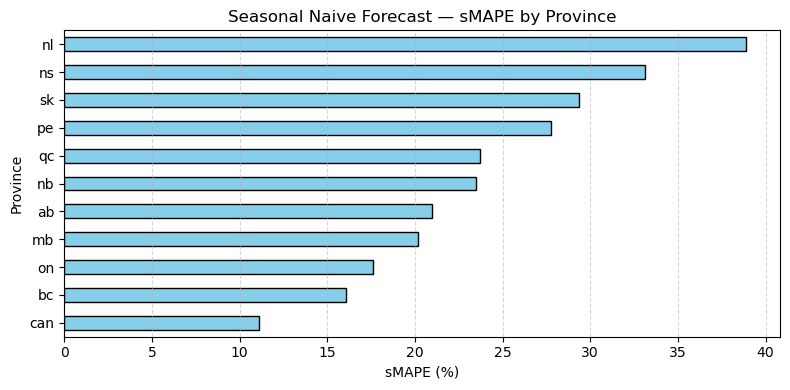

In [13]:
plt.figure(figsize=(8, 4))
prov_metrics_naive["sMAPE"].sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.xlabel("sMAPE (%)")
plt.ylabel("Province")
plt.title("Seasonal Naive Forecast — sMAPE by Province")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
'''#Linear Regression

def linreg_metrics_by_province(train_df, test_df, features, target="dwelling_starts"):
    rows = []
    for prov, gtrain in train_df.groupby("province"):
        gtest = test_df[test_df["province"] == prov]
        if gtest.empty:
            continue
        # Train model for this province
        X_train = gtrain[features]
        y_train = gtrain[target]
        X_test  = gtest[features]
        y_test  = gtest[target]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        res = metrics(y_test, y_pred)   # your existing metrics() function
        res["province"] = prov
        rows.append(res)
    return pd.DataFrame(rows).set_index("province")'''

'#Linear Regression\n\ndef linreg_metrics_by_province(train_df, test_df, features, target="dwelling_starts"):\n    rows = []\n    for prov, gtrain in train_df.groupby("province"):\n        gtest = test_df[test_df["province"] == prov]\n        if gtest.empty:\n            continue\n        # Train model for this province\n        X_train = gtrain[features]\n        y_train = gtrain[target]\n        X_test  = gtest[features]\n        y_test  = gtest[target]\n\n        model = LinearRegression()\n        model.fit(X_train, y_train)\n        y_pred = model.predict(X_test)\n\n        res = metrics(y_test, y_pred)   # your existing metrics() function\n        res["province"] = prov\n        rows.append(res)\n    return pd.DataFrame(rows).set_index("province")'

In [15]:
'''prov_linreg = linreg_metrics_by_province(train, test, features=feat_cols)
print(prov_linreg)
print("\nAverage across provinces:\n", prov_linreg.mean())'''

'prov_linreg = linreg_metrics_by_province(train, test, features=feat_cols)\nprint(prov_linreg)\nprint("\nAverage across provinces:\n", prov_linreg.mean())'

In [18]:
y_train = train["dwelling_starts"]
y_true  = test["dwelling_starts"]

In [66]:
MODEL_REGISTRY = {
    "lr": lambda **kw: make_pipeline(StandardScaler(), LinearRegression(**kw)),
    "rf": lambda **kw: RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, **kw),
    "ridge": lambda **kw: make_pipeline(StandardScaler(),Ridge(alpha=1.0, **kw)),
    "xgb": lambda **kw: XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, **kw),
}

def run_model(name, train, test, features, target="dwelling_starts", per_province=False, **model_kwargs):
    model = MODEL_REGISTRY[name](**model_kwargs)
    if not per_province:
        Xtr, ytr = train[features], train[target]
        Xte, yte = test[features],  test[target]
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        return ypred, metrics(yte, ypred)  # uses your existing metrics()
    else:
        rows = []
        for prov, gtr in train.groupby("province"):
            gte = test[test["province"] == prov]
            if gte.empty: 
                continue
            m = MODEL_REGISTRY[name](**model_kwargs)
            Xtr, ytr = gtr[features], gtr[target]
            Xte, yte = gte[features], gte[target]
            m.fit(Xtr, ytr)
            ypred = m.predict(Xte)
            res = metrics(yte, ypred)
            res["province"] = prov
            rows.append(res)
        import pandas as pd
        return pd.DataFrame(rows).set_index("province")


In [67]:
models = ['lr', 'rf', 'ridge', 'xgb',]

In [68]:
rows = []
for prov, gtr in train.groupby("province"):
    gte = test[test["province"] == prov]
    if gte.empty: 
        continue
    y_train = gtr["dwelling_starts"]
    y_true  = gte["dwelling_starts"]
    for name in models:
        m = MODEL_REGISTRY[name]()  # build model
        Xtr, Xte = gtr[feat_cols], gte[feat_cols]
        m.fit(Xtr, y_train)
        y_pred = m.predict(Xte)
        row = metrics(y_true, y_pred)  # MAE/RMSE/sMAPE
        row["MASE"] = mase(y_true, y_pred, y_train, season=4)
        row["model"] = name
        row["province"] = prov
        rows.append(row)
prov_cmp = pd.DataFrame(rows).set_index(["province","model"])
print(prov_cmp)

                        MAE          RMSE      sMAPE      MASE
province model                                                
ab       lr     1272.716598   1632.083965  15.718879  0.876480
         rf     1939.308009   2420.872771  22.424804  1.335541
         ridge  1272.865483   1633.340773  15.721971  0.876583
         xgb    2019.650843   2598.172150  23.826421  1.390870
bc       lr     1875.084523   2370.934867  17.249979  1.395734
         rf     2123.819769   2536.491069  19.600984  1.580882
         ridge  1907.597590   2392.718849  17.587444  1.419935
         xgb    2022.632174   2468.380630  18.785821  1.505562
can      lr     6507.661445   8721.283354  11.087923  1.360924
         rf     7805.139228   9477.641543  13.208541  1.632261
         ridge  6512.822813   8742.283490  11.098165  1.362003
         xgb    8800.806617  10286.965793  15.190361  1.840481
mb       lr      440.656849    544.851782  22.883262  1.947400
         rf      274.925849    379.710092  15.142161  1

In [69]:
# Helper: naive MAE on TRAIN (lag = season; for 1-step use season=1)
def _naive_mae_train(y_train: pd.Series, season: int = 4, eps: float = 1e-12) -> float:
    y = y_train.to_numpy()
    if len(y) <= season: 
        return np.nan
    denom = np.mean(np.abs(y[season:] - y[:-season]))
    return max(denom, eps)  # guard against divide-by-zero

# 1) Rolling CV — overall (all provinces combined)
def rolling_cv_overall(df, models, features, target="dwelling_starts", fh=4, initial=None):
    rows = []
    for tr, te in rolling_split(df, initial=initial, fh=fh):
        cutoff = tr["quarter"].max()
        denom = _naive_mae_train(tr[target], season=4)
        for name in models:
            y_pred, res = run_model(name, tr, te, features, target)  # uses your registry
            res["MASE"] = res["MAE"] / denom
            res["model"] = name
            res["cutoff"] = cutoff
            rows.append(res)
    return pd.DataFrame(rows).set_index(["cutoff", "model"]).sort_index()

# 2) Rolling CV — per-province
def rolling_cv_by_province(df, models, features, target="dwelling_starts", fh=4, initial=None):
    out = []
    for tr, te in rolling_split(df, initial=initial, fh=fh):
        cutoff = tr["quarter"].max()
        # denom per province from TRAIN
        denoms = {
            prov: _naive_mae_train(g[target], season=1)
            for prov, g in tr.groupby("province")
        }
        for name in models:
            # reuse your per-province branch; returns DF indexed by province with MAE/RMSE/sMAPE
            df_m = run_model(name, tr, te, features, target, per_province=True).copy()
            df_m["MASE"] = df_m["MAE"] / df_m.index.map(lambda p: max(denoms.get(p, np.nan), 1e-12))
            df_m["model"] = name
            df_m["cutoff"] = cutoff
            out.append(df_m.reset_index())
    return pd.concat(out, ignore_index=True).set_index(["cutoff", "province", "model"]).sort_index()


In [70]:
# Run rolling over the full dataframe you want to evaluate (e.g., model_df or df_v2)
overall_cv = rolling_cv_overall(model_df, models, feat_cols, fh=4)            # combined metrics + MASE per cutoff/model
prov_cv    = rolling_cv_by_province(model_df, models, feat_cols, fh=4)        # per-province metrics + MASE per cutoff/model

print(overall_cv.groupby("model").mean(numeric_only=True))  # average across folds
print(prov_cv.groupby(["province","model"]).mean(numeric_only=True))      # per-province averages

               MAE         RMSE      sMAPE      MASE
model                                               
lr     1414.529466  2537.593876  24.098738  0.878129
rf     1478.050241  2642.810245  23.524171  0.915545
ridge  1419.718544  2543.721646  24.477809  0.881354
xgb    1579.412664  3009.684414  23.854525  0.978497
                        MAE         RMSE      sMAPE      MASE
province model                                               
ab       lr     1284.464884  1486.882797  16.253495  1.669572
         rf     1633.193345  1866.778933  19.727144  2.118628
         ridge  1281.528176  1483.699579  16.225215  1.665815
         xgb    1702.854419  1952.131625  20.716993  2.211547
bc       lr     1494.981414  1767.244917  15.052326  1.974990
         rf     1489.772947  1772.192367  15.168497  1.969433
         ridge  1503.670383  1773.388898  15.144679  1.986087
         xgb    1496.152078  1834.358244  15.411534  1.971189
can      lr     4950.526986  5564.655291   8.952703  1.743725


In [71]:
summary = (
    prov_cv.groupby('province')[["MAE","RMSE","sMAPE","MASE"]]
           .mean()
           .round(1)
           .sort_values("MAE")
)
display(summary)

,MAE,RMSE,sMAPE,MASE
province,,,,
pe,62.5,73.9,28.0,1.1
nl,153.2,173.5,36.6,1.3
nb,183.4,213.1,23.1,0.9
mb,334.9,404.1,19.3,1.5
ns,340.4,396.1,26.6,1.4
sk,374.2,423.9,28.8,1.9
ab,1475.5,1697.4,18.2,1.9
bc,1496.1,1786.8,15.2,2.0
qc,2188.4,2495.9,18.6,2.2


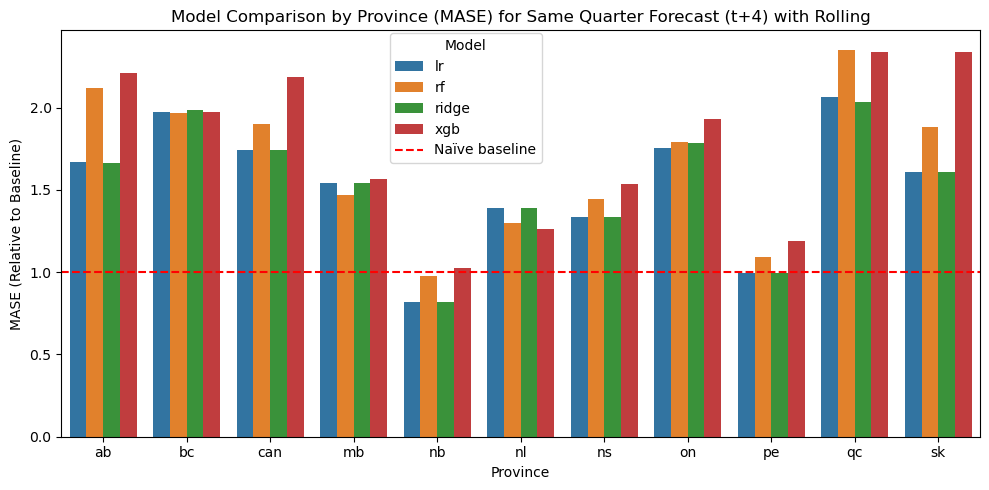

In [72]:
metric = "MASE"
plot_df = (
    prov_cv.groupby(["province", "model"])[metric]
           .mean()
           .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=plot_df, x="province", y=metric, hue="model")
plt.axhline(1.0, color="red", linestyle="--", label="Naïve baseline")
plt.title(f"Model Comparison by Province ({metric}) for Same Quarter Forecast (t+4) with Rolling")
plt.ylabel(f"{metric} (Relative to Baseline)")
plt.xlabel("Province")
plt.legend(title="Model", bbox_to_anchor=(.35, 1.01), loc="upper left")
plt.tight_layout()
plt.show()

### With holdout dataset

In [73]:
name = "lr"  # or "ridge", "rf", "xgb"
m_preds = []

for prov, gtr in train.groupby("province"):
    gte = test[test["province"] == prov]
    if gte.empty:
        continue

    model = MODEL_REGISTRY[name]()  # new model per province
    Xtr, ytr = gtr[feat_cols], gtr["y"]
    Xte, yte = gte[feat_cols], gte["y"]

    model.fit(Xtr, ytr)
    m_preds.append(pd.DataFrame({
        "province": prov,
        "quarter": gte["quarter"].values,
        "y_true": yte.values,
        "y_pred": model.predict(Xte)
    }))

preds_all = pd.concat(m_preds, ignore_index=True)
preds_all.head()

,province,quarter,y_true,y_pred
0,ab,2019-01-01,5398.500000,6287.560753
1,ab,2019-04-01,6701.166667,7175.941555
2,ab,2019-07-01,7826.666667,7298.913148
3,ab,2019-10-01,7426.166667,6585.661987
4,ab,2020-01-01,5989.500000,6050.281817


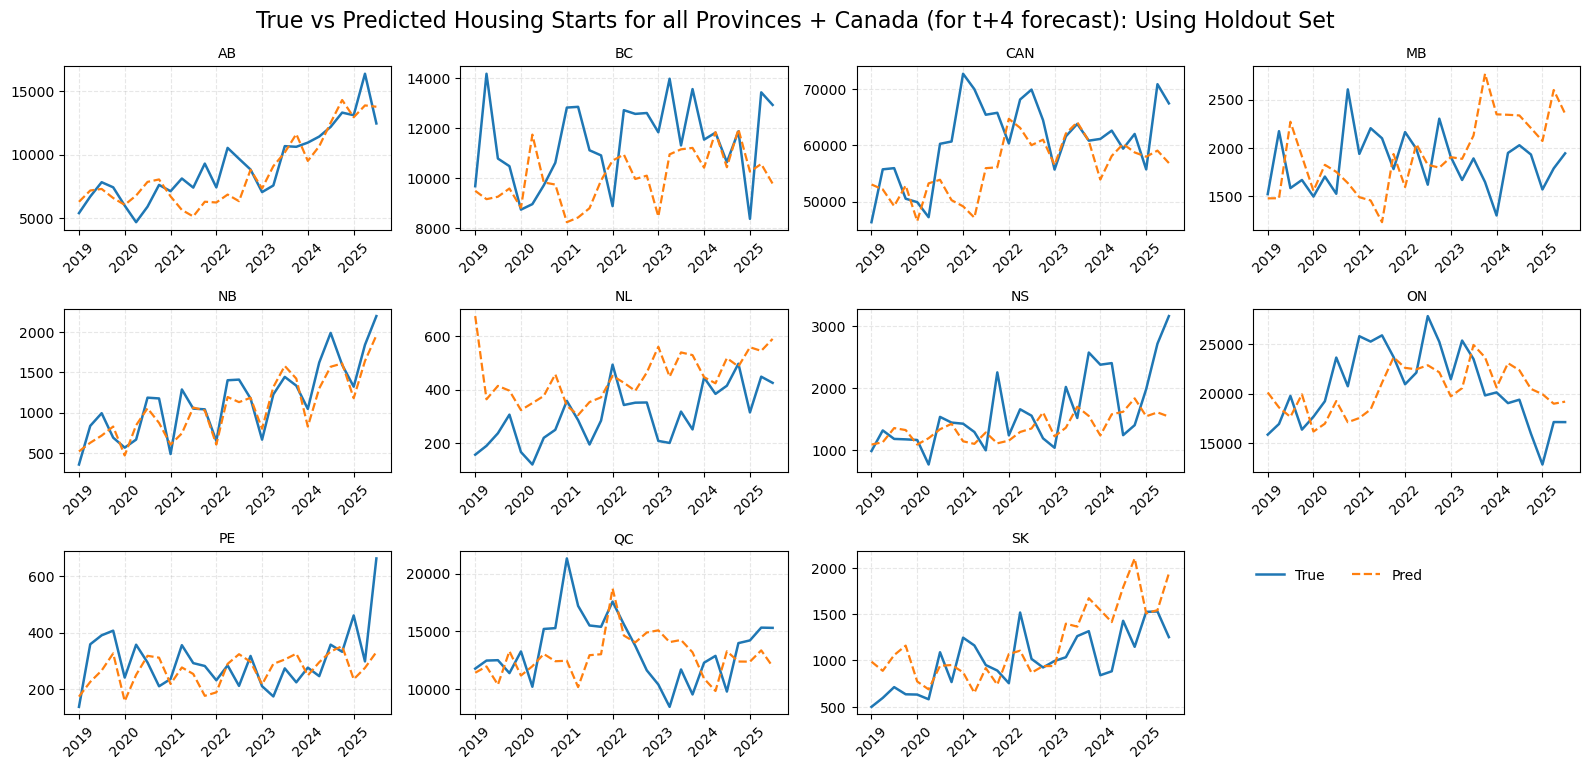

In [74]:
provs = sorted(preds_all["province"].unique())
n = len(provs)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
axes = axes.ravel()

for i, prov in enumerate(provs):
    ax = axes[i]
    g = preds_all[preds_all["province"] == prov].sort_values("quarter")
    ax.plot(g["quarter"], g["y_true"], label="True", linewidth=1.8)
    ax.plot(g["quarter"], g["y_pred"], "--", label="Pred", linewidth=1.6)
    ax.set_title(prov.upper(), fontsize=10)
    ax.tick_params(axis="x", labelrotation=45)
    ax.grid(True, linestyle="--", alpha=0.3)

# Hide any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", ncol=2, frameon=False, bbox_to_anchor=(.9, .23))

fig.suptitle("True vs Predicted Housing Starts for all Provinces + Canada (for t+4 forecast): Using Holdout Set", y=.98, fontsize=16)
plt.tight_layout()
plt.show()

### With rolling set

In [75]:
name = "lr"
rows = []
for tr, te in rolling_split(model_df, initial=None, fh=1):
    cutoff = tr["quarter"].max()
    for prov, gtr in tr.groupby("province"):
        gte = te[te["province"] == prov]
        if gte.empty:
            continue
        model = MODEL_REGISTRY[name]()
        Xtr, ytr = gtr[feat_cols], gtr["y"]
        Xte, yte = gte[feat_cols], gte["y"]
        model.fit(Xtr, ytr)
        rows.append(pd.DataFrame({
            "cutoff": cutoff,
            "province": prov,
            "quarter": gte["quarter"].values,
            "y_true": yte.values,
            "y_pred": model.predict(Xte)
        }))

preds_rolling_all_folds = pd.concat(rows, ignore_index=True)
preds_rolling_all_folds.head()

,cutoff,province,quarter,y_true,y_pred
0,2011-10-01,ab,2012-01-01,7705.083333,5184.597011
1,2011-10-01,bc,2012-01-01,6845.333333,6127.917422
2,2011-10-01,can,2012-01-01,51992.750000,44330.293333
3,2011-10-01,mb,2012-01-01,1706.000000,1177.255581
4,2011-10-01,nb,2012-01-01,579.500000,578.799258


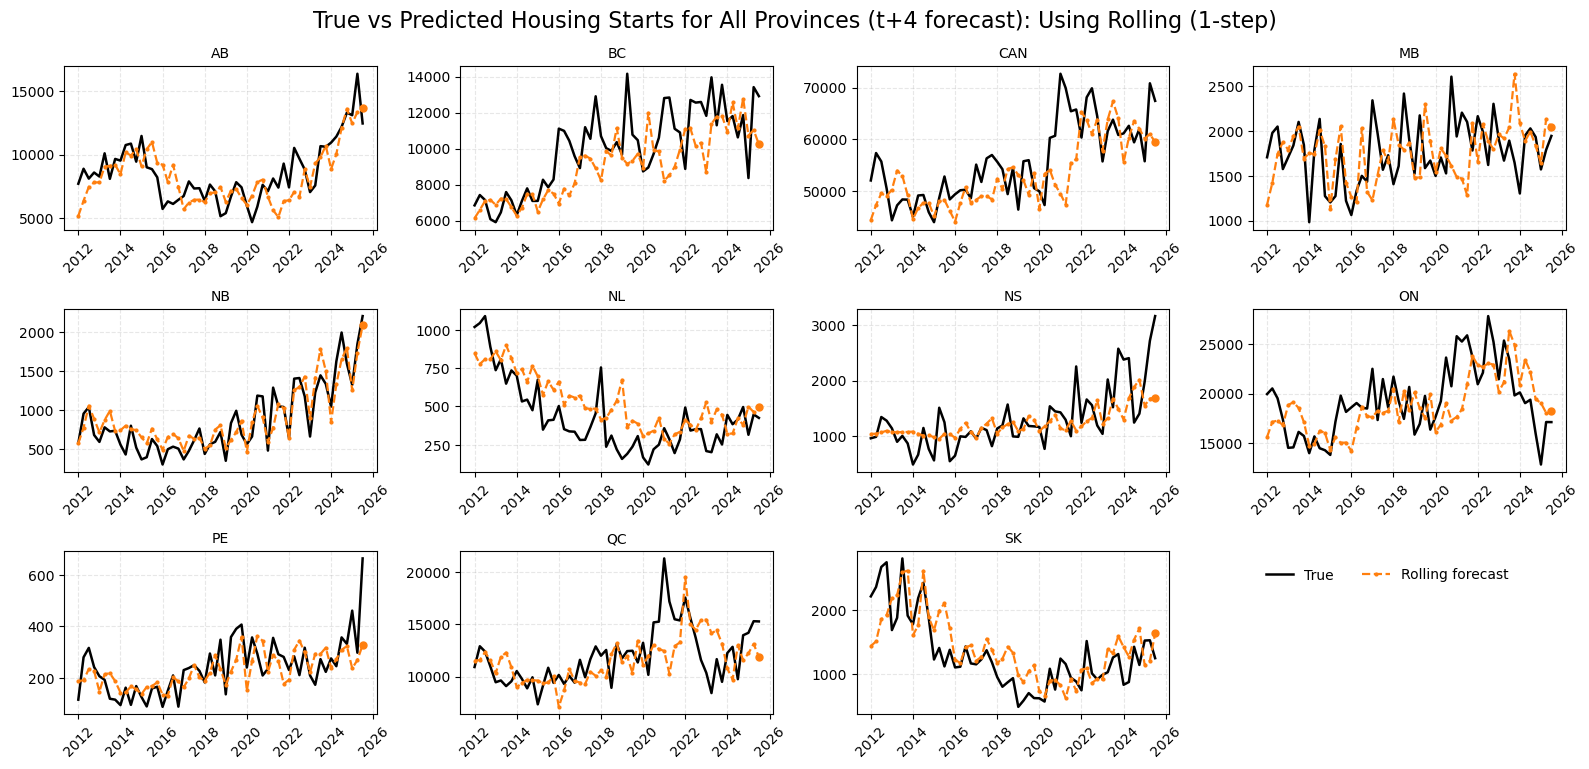

In [76]:
# Use your rolling dataframe
df = preds_rolling_all_folds.copy()
df["quarter"] = pd.to_datetime(df["quarter"])
df = df.sort_values(["province","quarter"])

provs = sorted(df["province"].unique())
cols, rows = 4, math.ceil(len(provs)/4)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
axes = axes.ravel()

for i, prov in enumerate(provs):
    ax = axes[i]
    g = df[df["province"] == prov]

    # True series
    truth = g.drop_duplicates("quarter")[["quarter","y_true"]]
    ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.8, label="True")

    # Rolling 1-step forecasts connected over time
    ax.plot(g["quarter"], g["y_pred"], "--", marker="o", ms=2,
            color="tab:orange", lw=1.6, label="Rolling forecast")

    # Emphasize latest forecast point
    ax.plot(g["quarter"].iloc[-1], g["y_pred"].iloc[-1], "o", color="tab:orange", ms=5)

    ax.set_title(prov.upper(), fontsize=10)
    ax.tick_params(axis="x", labelrotation=45)
    ax.grid(True, ls="--", alpha=0.3)

# Hide any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.87, .23))

fig.suptitle("True vs Predicted Housing Starts for All Provinces (t+4 forecast): Using Rolling (1-step)", y=.98, fontsize=16)
plt.tight_layout()
plt.show()